# TEDS End-to-End Simulation for TANGO-Carbon

### This notebook includes a first processing chain for TANGO Carbon. The chain is setup for consistent processing that is outlined in the following diagram:  

![title](./tango_e2es_Carbon_chain_PAM.png)

## Reference
+ ATBD
+ User manual

## Initialization

#### 1. Setup the working environment

In [51]:
import sys
import os
import yaml

# define  path to search for module
sys.path.append("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/")
os.chdir("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/examples/exp1.0_full_chain/")

#### 2. import TEDS modules

In [52]:
from teds.gm import geometry_module
from teds.sgm import geoscene_generation
from teds.sgm import Carbon_radiation_scene_generation
from teds.im import process_im
from teds.l1al1b import process_l1b
#from teds.siml1b import simplified_instrument_model_and_l1b_processor
#from teds.l1l2 import level1b_to_level2_processor
from teds.pam import pam_co2

#### 3. Select the target scene named after the targeted power plant 
Currently, four reference scenes can be used: (1) Matimba, (2) Jenschwalde, (3) Belchatow, (4) Lipetsk.


In [53]:
#station_name = 'Matimba'
station_name = 'Jaenschwalde'
#station_name = 'Belchatow'
#station_name = 'Lipetsk'

In [54]:
flag_gm     = False
flag_sgmgps = False
flag_sgmrad = False
flag_im     = False
flag_l1al1b = True

## Geometry Model

#### 1. runing the module

In [55]:
if(flag_gm):
    #configureation file
    gm_config= yaml.safe_load(open('./settings/gm_config_stations.yaml'))
    #select the list for the selected target
    gm_config = gm_config[station_name]
    geometry_module(gm_config)

#### 2. Visualization of the GM output

For plt_options use 'pixel' to show the geolocation of the pixel center points, and 'geometry' to show solar zenith angle, viewing zenith angle, solar azimuth angle, and viewing azimuth angle.

In [56]:
if(flag_gm):
    filen = gm_config['io_files']['output_gm']
    plt_option = 'geoloc'
    pam_co2.pam_gm_Tango_Carbon(filen, station_name, plt_option)

## Scene Generatior Module (SGM): Geo-Physical Scene

### 1. Run the module

In [57]:
if(flag_sgmgps):
    sgmgps_config= yaml.safe_load(open('./settings/geosgm_config_stations.yaml'))
    #select the list for the selected target
    sgmgps_config['io_files'] = sgmgps_config[station_name]['io_files']
    sgmgps_config['profile'] = 'orbit'
    geoscene_generation(sgmgps_config)

### 2. Vizualization of SGM-GPS output

plt_options is used to configure the output. 
* The input 'albedo Bxx' specifies the spectral band to be plotted. Here, xx is the band specification. Only bands can be plotted that are given in the input data (e.g. B08 is not available but the more norrow band B08A can be plotted). 
* The input 'Xxx' specifies the trace gas. Here, xx specifies the gas and can be CO2, NO, NO2, CH4, or H2O

In [58]:
if(flag_sgmgps):
    filen = sgmgps_config['io_files']['output_geo']
    plt_option = 'XCO2'
#    plt_option = 'albedo B11'
    pam_co2.pam_sgm_gps(filen, station_name, plt_option)

## Scene Generator Module (SGM): Radiation Scene

### 1. Execute SGM Radiation scene

In [59]:
if(flag_sgmrad):
    sgmrad_config= yaml.safe_load(open('./settings/radsgm_config_stations.yaml'))
    sgmrad_config['io_files'] = sgmrad_config[station_name]['io_files']
    sgmrad_config['profile'] = 'orbit'
    Carbon_radiation_scene_generation(sgmrad_config)

### 2. Visualization
Two panels are created. First a map of the radiometric scene for the wavelength wavel. On this map up to four pixels can be chosen using the tuple ialt_iact. The corresponding spectra are dipicted in the right panel.

In [60]:
if(flag_sgmrad):
    filen_rad = sgmrad_config['io_files']['output_rad']
    wavel = 1600.0
    ialt_iact = [[50,50], [100,3], [105,79], [0,1]]
    pam_co2.pam_sgm_rad(filen_rad, station_name, wavel, ialt_iact)

## Instrument Model (IM)

### 1. Executing the model

In [61]:
if(flag_im):
    im_config= yaml.safe_load(open('./settings/im_config.yaml'))
    im_config['io'] = im_config[station_name]['io']
    process_im(im_config)

[21:16:42] [WARNING] unrecognized input parameter: Matimba
[21:16:42] [WARNING] unrecognized input parameter: Jaenschwalde
[21:16:42] [WARNING] unrecognized input parameter: Belchatow
[21:16:42] [WARNING] unrecognized input parameter: Lipetsk
[21:16:42] Processing from SGM to l1a


##########################
# Tango instrument model #
##########################
Version                 : 0.0.1
Commit hash             : 9c2eb708
Date and timezone       : 2024 October 29 Tue
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.8.0-47-generic

##############################
# Reading CKD and input data #
##############################


[21:16:42] Reading input data
[21:16:46] Reading binning table
[21:16:46] Changing wavelength grid



#################
# Forward model #
#################


[21:20:57] Converting from radiance
[21:20:57] Mapping to detector
[21:20:59] Including stray light
[21:22:22] Including pixel mask
[21:22:22] Including PRNU
[21:22:22] Including non-linearity
[21:22:23] Including dark signal
[21:22:23] Including offset
[21:22:23] Including binning
[21:22:24] Writing output data



###########
# Success #
###########


### 2. Plotting detector images

The generated L0 data contain a series of detector images. The index ialt points to the image.

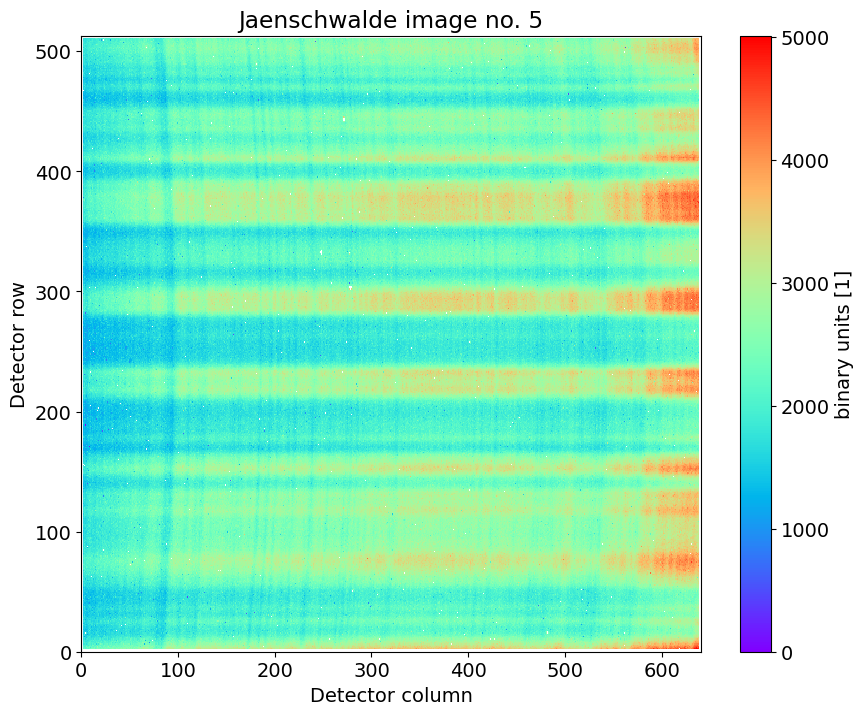

In [62]:
if(flag_im):
    filen_rad = im_config['io']['l1a']
    ialt = 5
    title = station_name + f' image no. {ialt}'
    pam_co2.pam_im(filen_rad, ialt, title)

## L1A to L1B Processor

The L1A-L1B processor is a module for the Payload Data Ground Segement. It calibrated the simulated detector images.

### 1. Execute Processor

In [63]:
if(flag_l1al1b):
    l1al1b_config= yaml.safe_load(open('./settings/l1al1b_config.yaml'))
    l1al1b_config['io'] = l1al1b_config[station_name]['io']
    process_l1b(l1al1b_config)

### 2. Comparision with SGM-RAD output